## **Watermark Detection in Images**


- ( Download the dataset from : https://www.kaggle.com/datasets/felicepollano/watermarked-not-watermarked-images )

- Github Repo - https://github.com/Naresh-19/Watermark-Detection-System/

- Drive Link - https://drive.google.com/drive/folders/1FTPESGRV9w2WFD0KrupjNMpinGyiimYV?usp=sharing

- Use README.md file in the DRIVE LINK for set up.  - https://drive.google.com/file/d/1_mvMpnfqzpM9rPFhvci90mu-jqP5axyk/view?usp=sharing

- For Evaluated Result - https://github.com/Naresh-19/Watermark-Detection-System/tree/main/Evaluated_Results

- NOTE : If you face any difficulty in downloading the dataset, You can directly use my synthetic dataset which is available in the drive link by extracting it (https://drive.google.com/file/d/10Kosb25MjrPfjAVEiqPF5HjpxdsFqMzH/view?usp=sharing) and start executing from `PHASE 3`.


# Phase 0: Setup

The setup phase initializes the project path and prepares to access the dataset.

- Uses `os` and `pathlib.Path` to list all file paths under the raw dataset folder:  
  `dataset/wm-nowm/`.
- Counts and prints the total number of images available for processing.

- Also Change the base_path directory based on your system path.

In [ ]:
import os
from PIL import Image 
from pathlib import Path

base_path = Path(r"D:\project\Watermark_Detection\dataset")

file_paths = []

for root, dirs, files in os.walk(base_path / "wm-nowm"):
    for file in files:
        full_path = Path(root) / file
        file_paths.append(full_path)


print(f"Total files found: {len(file_paths)}\n")


Total files found: 31576



# Phase 1: Cleaning and Filtering Images

This phase ensures data quality by selecting only valid image files.

- Iterates through `watermark` and `no-watermark` folders under `wm-nowm/train/`.
- Verifies each image using `PIL.Image.verify()` to check for corruption.
- Copies the first 1000 valid images per category to `wm-nowm-cleaned/train/`.

In [ ]:
import os
from pathlib import Path
from PIL import Image
import shutil

source_root = base_path / "wm-nowm\train"
destination_root = base_path / "wm-nowm-cleaned\train"

categories = ["watermark", "no-watermark"]
max_images_per_category = 1000

for category in categories:
    os.makedirs(destination_root / category, exist_ok=True)

def is_valid_image(path):
    try:
        with Image.open(path) as img:
            img.verify()  
        return True
    except Exception:
        return False

for category in categories:
    print(f"Processing category: {category}")

    source_folder = source_root / category
    destination_folder = destination_root / category
    
    valid_images = []
    
    for img_file in source_folder.glob("**/*"):
        if img_file.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".webp"]:
            if is_valid_image(img_file):
                valid_images.append(img_file)
        
        if len(valid_images) >= max_images_per_category:
            break

    print(f"{len(valid_images)} valid images found for '{category}'")

    for idx, valid_img in enumerate(valid_images):
        target_path = destination_folder / f"{category}_{idx}{valid_img.suffix}"
        shutil.copy2(valid_img, target_path)

print("\nCleaning & filtering completed successfully.")


Processing category: watermark
1000 valid images found for 'watermark'
Processing category: no-watermark
1000 valid images found for 'no-watermark'

Cleaning & filtering completed successfully.


# Phase 2: Train/Validation Split

Splits the cleaned dataset into `train` and `val` sets for both categories.

- Randomly shuffles valid images.
- Allocates 750 images per category to `train`, and 250 to `val`.
- Saves the result under `wm-nowm-final/train/` and `wm-nowm-final/val/`.



In [ ]:
import os
import random
from pathlib import Path
import shutil

random.seed(42)

cleaned_root = base_path / "wm-nowm-cleaned\train"

final_dataset_root = base_path / "wm-nowm-final"

categories = ["watermark", "no-watermark"]
train_count = 750
val_count = 250

for split in ['train', 'val']:
    for category in categories:
        os.makedirs(final_dataset_root / split / category, exist_ok=True)

for category in categories:
    print(f"Processing category: {category}")
    
    all_images = list((cleaned_root / category).glob("*"))
    random.shuffle(all_images)

    train_images = all_images[:train_count]
    val_images = all_images[train_count:train_count + val_count]

    print(f"Train images: {len(train_images)} | Val images: {len(val_images)}")

    for img_path in train_images:
        target_path = final_dataset_root / 'train' / category / img_path.name
        shutil.copy2(img_path, target_path)

    for img_path in val_images:
        target_path = final_dataset_root / 'val' / category / img_path.name
        shutil.copy2(img_path, target_path)

print("\nTrain/Val split completed successfully.")


Processing category: watermark
Train images: 750 | Val images: 250
Processing category: no-watermark
Train images: 750 | Val images: 250

Train/Val split completed successfully.


# Phase 3: Device and Path Configuration

Configures the environment and verifies dataset structure.

- Detects if a GPU is available using `torch.cuda`.
- Verifies presence of expected folders like `train/watermark`, `val/no-watermark`, etc.
- Ensures the model does not fail due to missing directories.

In [ ]:
import os
import random
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from pathlib import Path

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device selected: {device}")

data_root = base_path / "wm-nowm-final"

assert (data_root / 'train' / 'watermark').exists(), "Train/Watermark folder missing!"
assert (data_root / 'train' / 'no-watermark').exists(), "Train/No-Watermark folder missing!"
assert (data_root / 'val' / 'watermark').exists(), "Val/Watermark folder missing!"
assert (data_root / 'val' / 'no-watermark').exists(), "Val/No-Watermark folder missing!"

print("Dataset folders verified.")



Device selected: cuda
Dataset folders verified.


# Phase 4: Data Transforms and Loaders

( Note :  Change the dataset directory for train_data and val_data )


Applies transforms and prepares data loaders.

- Defines separate `transform_train` and `transform_val` using `torchvision.transforms`.
- Normalizes images with ImageNet mean and standard deviation.
- Uses `torchvision.datasets.ImageFolder` to load datasets.
- Initializes PyTorch `DataLoader` objects for training and validation.

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

input_size = 256

transform_train = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(root=r'D:\project\Watermark_Detection\dataset\wm-nowm-final\train', transform=transform_train)
val_data = datasets.ImageFolder(root=r'D:\project\Watermark_Detection\dataset\wm-nowm-final\val', transform=transform_val)

batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

print(f"Training dataset size: {len(train_data)}")
print(f"Validation dataset size: {len(val_data)}")


Training dataset size: 1915
Validation dataset size: 500


# Phase 5: Model Definition - ResNeXt

Initializes a `ResNeXt50_32x4d` model for binary classification.

- Loads the pre-trained ResNeXt model.
- Replaces the final classification layer to output 2 classes.
- Moves the model to GPU.

In [ ]:
import torchvision.models as models
import torch.nn as nn

model_resnext = models.resnext50_32x4d(pretrained=True)

num_ftrs_resnext = model_resnext.fc.in_features
model_resnext.fc = nn.Linear(num_ftrs_resnext, 2) 

model_resnext = model_resnext.to('cuda')  


d:\Users\HP-5C\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Users\HP-5C\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Phase 6: Model Definition - ConvNeXt

Initializes a `ConvNeXt Tiny` model using the `timm` library.

- Loads a pre-trained ConvNeXt model via `timm.create_model`.
- Sets `num_classes=2` to match the classification task.
- Moves the model to GPU.

In [11]:
import timm

model_convnext = timm.create_model('convnext_tiny', pretrained=True, num_classes=2)

model_convnext = model_convnext.to('cuda')


# Phase 7: Model Definition - EfficientNet

Initializes an `EfficientNet B3a` model using the `timm` library.

- Loads a pre-trained EfficientNet model.
- Configured for binary classification (`num_classes=2`).
- Moves the model to GPU.

---

In [12]:
model_effnet = timm.create_model('efficientnet_b3', pretrained=True, num_classes=2)

model_effnet = model_effnet.to('cuda')


# Phase 8: Loss Function and Optimizers

Defines the loss function and optimizers for each model.

- Uses `CrossEntropyLoss` as the loss criterion.
- Applies `AdamW` optimizer with a learning rate of `1e-4` for:
  - ResNeXt
  - ConvNeXt
  - EfficientNet

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer_resnext = optim.AdamW(model_resnext.parameters(), lr=1e-4)
optimizer_convnext = optim.AdamW(model_convnext.parameters(), lr=1e-4)
optimizer_effnet = optim.AdamW(model_effnet.parameters(), lr=1e-4)


# Phase 9: Training Loop

Defines a reusable function `train_model()` to train any of the defined models.

- Trains for a given number of epochs (default: 3).
- Tracks loss and accuracy for both train and val sets.
- Saves the best-performing model weights during validation.
- Prints epoch-wise and final results.

---

In [ ]:
import time
from tqdm import tqdm

def train_model(model, dataloaders, criterion, optimizer, num_epochs=3):
    since = time.time()
    val_acc_history = []
    train_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to('cuda')
                labels = labels.to('cuda')

                optimizer.zero_grad()  

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()  
                        optimizer.step() 

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60}m {time_elapsed % 60}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history


# Phase 10: Train Model

Trains the selected model(s) using the `train_model` function.

- Currently, Only ConvNext models are trained , (Reason : `ConvNext Performed Well`)
- Stores training and validation accuracy history for visualization.

---

In [10]:
import copy
# # Train ResNeXt model
# print("Training ResNeXt...")
# model_resnext, train_acc_history_resnext, val_acc_history_resnext = train_model(
#     model_resnext, dataloaders, criterion, optimizer_resnext, num_epochs=3
# )

# Train ConvNeXt model
print("Training ConvNeXt...")
model_convnext, train_acc_history_convnext, val_acc_history_convnext = train_model(
    model_convnext, dataloaders, criterion, optimizer_convnext, num_epochs=3
)

# # Train EfficientNet model
# print("Training EfficientNet...")
# model_effnet, train_acc_history_effnet, val_acc_history_effnet = train_model(
#     model_effnet, dataloaders, criterion, optimizer_effnet, num_epochs=3
# )


Training ConvNeXt...
Epoch 0/2
----------


100%|██████████| 60/60 [13:55<00:00, 13.93s/it]


train Loss: 0.4512 Acc: 0.7875


100%|██████████| 16/16 [00:15<00:00,  1.02it/s]


val Loss: 0.4028 Acc: 0.8060

Epoch 1/2
----------


100%|██████████| 60/60 [13:15<00:00, 13.26s/it]


train Loss: 0.2542 Acc: 0.8935


100%|██████████| 16/16 [00:13<00:00,  1.16it/s]


val Loss: 0.2705 Acc: 0.9080

Epoch 2/2
----------


100%|██████████| 60/60 [13:33<00:00, 13.55s/it]


train Loss: 0.2177 Acc: 0.9076


100%|██████████| 16/16 [00:11<00:00,  1.44it/s]

val Loss: 0.2877 Acc: 0.8960

Training complete in 41.0m 25.363177061080933s
Best val Acc: 0.9080


# Phase 11: Model Saving

Saves the trained model weights to disk.

- Saves ConvNeXt weights as `logoconvnext_best_model.pth`.
- Includes optional commented lines to save ResNeXt and EfficientNet models as well.

In [ ]:
import torch
# Save the best model weights
# torch.save(model_resnext.state_dict(), 'resnext_best_model.pth')
torch.save(model_convnext.state_dict(), 'logoconvnext_best_model.pth')
# torch.save(model_effnet.state_dict(), 'effnet_best_model.pth')


In [22]:
import os
import shutil
import random

# Paths
src_root = base_path / "wm-nowm"
dst_root = base_path / "wm-nowm-final"

# Make sure destination has train/val/test folders
for split in ['train', 'val', 'test']:
    for class_name in os.listdir(os.path.join(src_root, 'train')):
        os.makedirs(os.path.join(dst_root, split, class_name), exist_ok=True)

# Copy train and val fully first
for split in ['train', 'val']:
    src_split_path = os.path.join(src_root, split)
    dst_split_path = os.path.join(dst_root, split)

    for class_name in os.listdir(src_split_path):
        src_class_path = os.path.join(src_split_path, class_name)
        dst_class_path = os.path.join(dst_split_path, class_name)

        for filename in os.listdir(src_class_path):
            src_file = os.path.join(src_class_path, filename)
            dst_file = os.path.join(dst_class_path, filename)
            shutil.copy(src_file, dst_file)

# Now randomly move few images from train/val to test
num_test_images_per_class = 20  # you can change this number

for split in ['train', 'val']:
    split_path = os.path.join(dst_root, split)
    for class_name in os.listdir(split_path):
        class_path = os.path.join(split_path, class_name)
        all_images = os.listdir(class_path)
        random.shuffle(all_images)

        test_images = all_images[:num_test_images_per_class]

        for img in test_images:
            src_img_path = os.path.join(class_path, img)
            dst_img_path = os.path.join(dst_root, 'test', class_name, img)
            shutil.move(src_img_path, dst_img_path)

print("Dataset restructuring completed!")


Dataset restructuring completed!


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import os
import timm
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

# Set paths and class names
val_dir = r"D:\project\Watermark_Detection\dataset\wm-nowm-final\val"
class_names = ['no-watermark', 'watermark']
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

# Load model
model = timm.create_model('convnext_tiny', pretrained=True, num_classes=2)
model.load_state_dict(torch.load('logoconvnext_best_model.pth', map_location=torch.device('cpu')))
model.eval()

# Define transform
input_size = 256
transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare data
y_true = []
y_pred = []

# Loop through classes and images
for class_name in class_names:
    class_path = os.path.join(val_dir, class_name)
    label = class_to_idx[class_name]

    for img_name in tqdm(os.listdir(class_path), desc=f"Processing {class_name}"):
        img_path = os.path.join(class_path, img_name)

        try:
            image = Image.open(img_path).convert('RGB')
            image = transform(image).unsqueeze(0)

            with torch.no_grad():
                output = model(image)
                _, predicted = torch.max(output, 1)

            y_true.append(label)
            y_pred.append(predicted.item())
        except Exception as e:
            print(f"Failed to process {img_path}: {e}")

# Generate metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Processing watermark: 100%|██████████| 3529/3529 [05:38<00:00, 10.44it/s]


Classification Report:
              precision    recall  f1-score   support

no-watermark       0.89      0.89      0.89      3519
   watermark       0.89      0.89      0.89      3529

    accuracy                           0.89      7048
   macro avg       0.89      0.89      0.89      7048
weighted avg       0.89      0.89      0.89      7048

Confusion Matrix:
[[3141  378]
 [ 386 3143]]


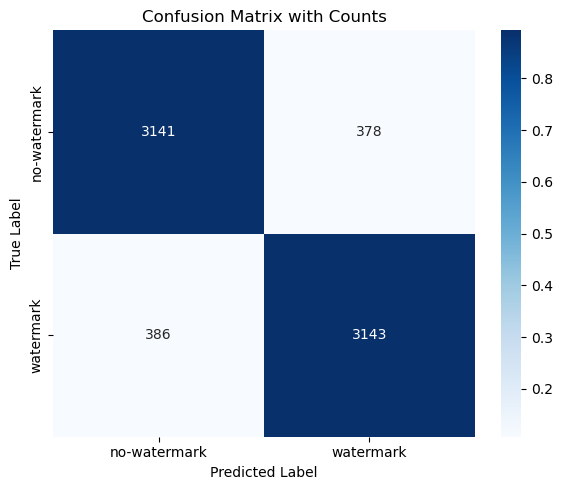

In [4]:
import numpy as np
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=cm, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix with Counts")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


              precision    recall  f1-score    support
no-watermark   0.890559  0.892583  0.891570  3519.0000
watermark      0.892644  0.890621  0.891631  3529.0000
accuracy       0.891600  0.891600  0.891600     0.8916
macro avg      0.891601  0.891602  0.891600  7048.0000
weighted avg   0.891603  0.891600  0.891600  7048.0000


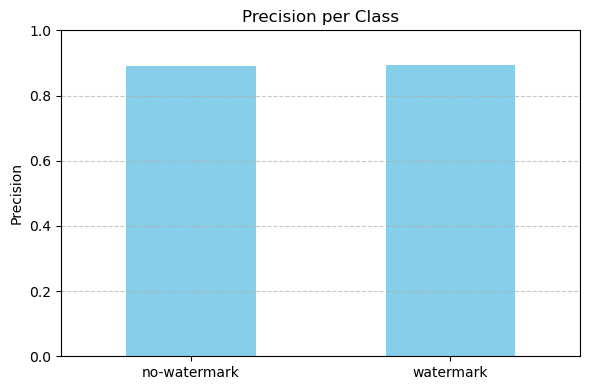

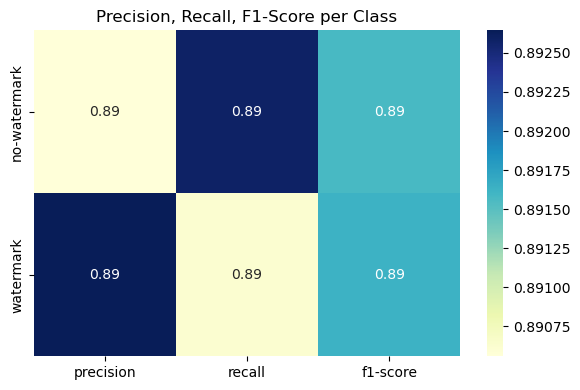

In [2]:
# Classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

# Plot precision bar chart
plt.figure(figsize=(6, 4))
report_df.loc[class_names, "precision"].plot(kind='bar', color='skyblue')
plt.title("Precision per Class")
plt.ylabel("Precision")
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Plot heatmap of precision, recall, F1-score
plt.figure(figsize=(6, 4))
metrics_only = report_df.loc[class_names, ['precision', 'recall', 'f1-score']]
sns.heatmap(metrics_only, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Precision, Recall, F1-Score per Class")
plt.tight_layout()
plt.show()

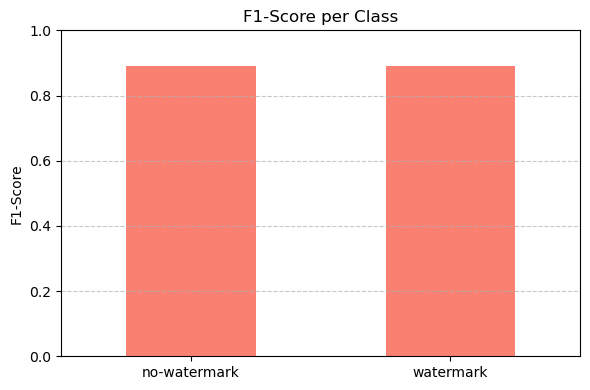

In [14]:
# F1-Score per class
plt.figure(figsize=(6, 4))
report_df.loc[class_names, "f1-score"].plot(kind='bar', color='salmon')
plt.title("F1-Score per Class")
plt.ylabel("F1-Score")
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


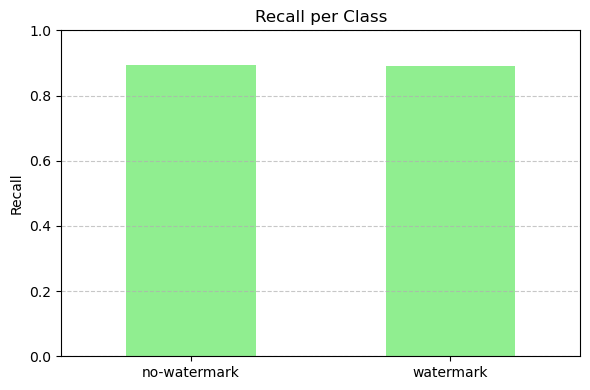

In [15]:
# Recall per class
plt.figure(figsize=(6, 4))
report_df.loc[class_names, "recall"].plot(kind='bar', color='lightgreen')
plt.title("Recall per Class")
plt.ylabel("Recall")
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
